# Pythonを用いた宇宙モデルのシミュレーション

## 宇宙の発展とフリードマン方程式
フリードマン方程式とは，宇宙のスケールの時間発展を記述する方程式．この式を時間で積分することにより宇宙の進化を求めることができる．

以下は圧力のない物質が支配する場合の宇宙の進化を記述した方程式である．
\begin{equation}
\ddot{a} = -4\pi G \rho_0 \frac{a_0^3}{3a^2} + \frac{\Lambda a}{3} \label{a}\tag{1}
\end{equation}

$$a:スケール因子, G:万有引力定数, \rho_0:宇宙の平均物質エネルギー密度の現在値, a_0:スケール因子の現在値, \Lambda:宇宙項$$

今回は，式(\ref{a})を数値計算がしやすいようにより簡単にした次の方程式(\ref{b})を新しい時間座標$X$で積分し，宇宙進化のシミュレーションを行う．

\begin{equation}
\bf Y'' = -\frac{\sigma_0}{Y^2} + (\sigma_0 - q_0)Y \label{b}\tag{2}
\end{equation}

$$ X = H_0 t(新しい時間座標), Y = \frac{a}{a_0}(スケール因子の現在値を長さの単位に採用した新しい変数), \sigma_0:密度パラメーター, q_0:減速パラメーター(スケール因子の相対的な加速度を与えるもの) $$

## プログラムへの実装
- フリードマン方程式を関数定義
- 回転変換を行う関数の定義
- フリードマン方程式を積分し，その３次元化を行うクラスの定義
    - フリードマン方程式の積分の過程
        - $X_0=0$で$Y_0=1$かつ$Y'_0=1$という初期条件を与える
        - 定義した初期条件から，正の時間の最大値$X_{max}$までフリードマン方程式を積分し未来を計算
        - 同様に，同一の初期条件から，負の時間の最小値$X_{min}$までフリードマン方程式を積分し過去を計算
    - 積分した結果を格納した配列を結合し，座標を２次元から３次元へと拡張
        - 計算して得られた過去と未来の結果を時間と規格化されたスケール因子それぞれの配列について結合
        - 回転変換前の３次元座標を定義
          次の要件を満たすように座標を１つの配列に定義
            - x座標：規格化されたスケール因子
            - y座標：すべて0
            - z座標：時間座標
    - 座標を回転変換して，新しい座標を計算
        - 回転変換を行う関数を呼び出し，

## calculate.pyの作成

### 1. 使用するライブラリのインポート

In [1]:
"""フリードマン方程式の数値計算用モジュール．"""
# 使用するライブラリをインポート
import numpy as np
from scipy.integrate import solve_ivp

### 2. フリードマン方程式の関数定義

In [2]:
def friedmann_equation(time, variables, sigma_0, q_0):
    """
    フリードマン方程式の定義
    Args:
        time: 時間座標X
        variables: 変数Yの初期条件を格納した配列 [Y_0, dY_dX_0]
        sigma_0: 密度パラメーター
        q_0: 減速パラメーター

    Returns:
        np.array: フリードマン方程式の結果を表す配列 [dY_dX, ddY_dXdX]
    """
    normalized_scale_factor_a = variables[0]
    dY_dX = variables[1]
    ddY_dXdX = -sigma_0/normalized_scale_factor_a**2 + (sigma_0 - q_0)*normalized_scale_factor_a
    return np.array([dY_dX, ddY_dXdX])

### 3. 回転変換を行う関数の定義

In [3]:
def rotate_coordinates(theta, coordinate_matrix):
    """
    座標をz軸周りに回転変換する関数
    Args:
        theta: 回転角度（ラジアン）
        coordinate_matrix: 変換する座標を表す行列（3xNのNumPy配列）

    Returns:
        np.array: 回転変換後の座標行列（3xNのNumPy配列）
    """
    # 回転行列の定義（Z軸周り）
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta),  np.cos(theta), 0],
                                [0.0, 0.0, 1.0]])
    return rotation_matrix @ coordinate_matrix

### フリードマン方程式を積分し，その３次元化を行うクラスの定義

In [4]:
class FriedmannEquationIntegrator:
    """
    数値積分を実行し，グラフ化のためのx,y,z座標を計算するためのクラス
    """

    def __init__(self,
                 ode_function,
                 coordinate_function,
                 sigma_0,
                 q_0,
                 K,
                 Lambda):
        """
        コンストラクタ：インスタンス化されたときに最初に呼ばれる特別なメソッド，データの初期化を行う
        Args:
            ode_function: 常微分方程式を定義した関数
            coordinate_function: 座標変換を定義した関数
            sigma_0: 密度パラメーター
            q_0: 減速パラメーター
            K：宇宙の空間曲率
            Lambda:宇宙項
        """
        self.ode_function = ode_function
        self.coordinate_function = coordinate_function
        self.sigma_0 = sigma_0
        self.q_0 = q_0
        self.K = K
        self.Lambda = Lambda
        
        self.initial_variables = np.array([1.0, 1.0])
        self.time_plus = np.array([0.0, 6.0])
        self.time_minus = np.array([0.0, -1.0])
        self.num_points = 50
        self.phi = np.linspace(0, 2*np.pi, self.num_points).reshape(1, self.num_points)

    def integrate(self, time_direction):
        """
        時間方向にフリードマン方程式を積分するメソッド
        Args:
            time_direction: 時間方向を表すタプル (t0, t1)

        Returns:
            sol: 積分結果を含むオブジェクト
        """
        sol = solve_ivp(self.ode_function,
                        time_direction,
                        self.initial_variables,
                        method='RK45',
                        t_eval=None,
                        rtol=1e-8,
                        atol=1e-10,
                        args=(self.sigma_0, self.q_0),
                        dense_output=True)
        return sol

    def concatenate_sol_array(self):
        """
        積分して得られたndarray型の配列を結合し，回転変換前のx,y,z座標を求めるメソッド

        Returns:
            time_array: 過去の計算結果と未来の計算結果を結合した時間座標Xの配列
            coordinate: 過去の計算結果と未来の計算結果を結合し，条件に沿って定義した回転変換前の３次元座標の配列
        """
        sol_plus = self.integrate(self.time_plus)
        sol_minus = self.integrate(self.time_minus)
        time_array = np.concatenate([sol_minus.t[::-1], sol_plus.t])
        scale_array = np.concatenate([sol_minus.y[0][::-1], sol_plus.y[0]])
        coordinate = np.array(
            [scale_array, np.zeros(len(time_array)), time_array]
        ).reshape(3, len(time_array))
        return time_array, coordinate

    def calculate_rotated_coordinates(self):
        """
        回転行列によって変換したx,y,z座標を求めるメソッド
        Returns:
            x_new: 回転変換後のx座標の配列
            y_new: 回転変換後のy座標の配列
            z_new: 回転変換後のz座標の配列
        """
        time_array, coordinate = self.concatenate_sol_array()
        new_coordinate = np.array(
            [
                np.array([
                    self.coordinate_function(self.phi[0, i], coordinate[:, j])
                    for i in range(self.phi.shape[1])
                ]).T
                for j in range(len(time_array))
            ]
        )
        x_new = new_coordinate[:, 0, :]
        y_new = new_coordinate[:, 1, :]
        z_new = new_coordinate[:, 2, :]
        return x_new, y_new, z_new


## calculate.pyの動作テスト

### 1. rotate_coordinates(theta, coordinate_matrix)関数の動作確認

In [5]:
# 適当な３×３の行列を用意
coordinate_matrix = np.arange(9).reshape((3, 3))
# 行列の中身の確認
coordinate_matrix

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [6]:
# 回転角の設定
theta = np.pi/3
# 回転変換を施す関数を上で定義した行列に対して実行
new_coordinate_matrix = rotate_coordinates(theta, coordinate_matrix)
# 回転変換後の行列の確認
new_coordinate_matrix

array([[-2.59807621, -2.96410162, -3.33012702],
       [ 1.5       ,  2.8660254 ,  4.23205081],
       [ 6.        ,  7.        ,  8.        ]])

### 2. インスタンス化

In [7]:
integrator = FriedmannEquationIntegrator(
    ode_function=friedmann_equation,
    coordinate_function=rotate_coordinates,
    sigma_0=0.5,  # 適切な値に置き換える
    q_0=0.3,     # 適切な値に置き換える
    K=0.0,       # 適切な値に置き換える
    Lambda=0.0   # 適切な値に置き換える
)

### 3. concatenate_sol_arrayメソッドの呼び出し

In [8]:
coordinate_array = integrator.concatenate_sol_array()[1]
normalized_scale_factor = coordinate_array[0, :]
time = coordinate_array[2, :]

In [9]:
# 配列の形状確認
coordinate_array.shape

(3, 317)

### 4. フリードマン方程式の計算結果の確認（２次元）

Text(0, 0.5, '$a_0 \\ / \\ a$')

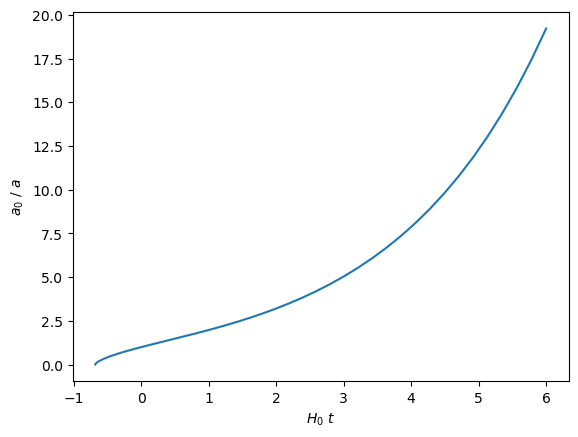

In [10]:
# グラフ化するために必要なライブラリのインポート
import matplotlib.pyplot as plt
# グラフの描画領域の設定
fig = plt.figure()
# グラフを描画領域にプロット
plt.plot(time, normalized_scale_factor)
# 軸ラベルの設定
plt.xlabel(r"$H_0 \ t$")
plt.ylabel(r"$a_0 \ / \ a$")

### 5. calculate_rotated_coordinatesメソッドの呼び出し

In [11]:
x_new, y_new, z_new = integrator.calculate_rotated_coordinates()

In [12]:
x_new.shape

(317, 50)

### 6. 回転変換後の座標の可視化(３次元)

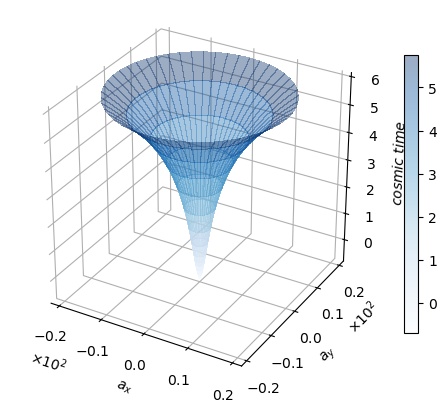

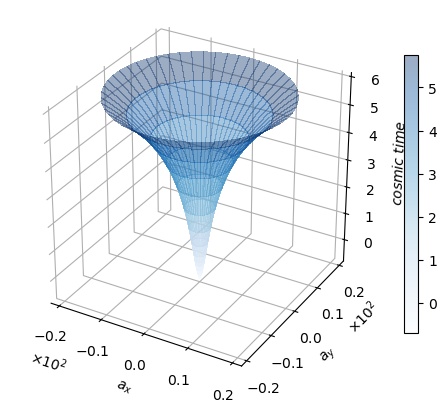

In [13]:
#「output.py」で作成した関数をインポート
from output import draw_plot
# 関数の実行
draw_plot(x_new, y_new, z_new)